In [1]:
!pip install transformers datasets accelerate
!pip install librosa

In [2]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification, AutoModelForAudioClassification
from datasets import load_dataset, Dataset
import torch
import sklearn
import json, os, time, glob

import numpy as np
import librosa
from collections import defaultdict
from pprint import pprint

from transformers import Trainer

import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_path = "../../../data/16k_data"
glob.glob(data_path + '/**')

['../../../data/16k_data/training.npz', '../../../data/16k_data/meta.json']

In [4]:
arrays = np.load(f'{data_path}/training.npz')
meta = json.load(open(f'{data_path}/meta.json', 'r'))

pprint(meta)

{'labelfile': 'project-6-at-2024-11-23-15-47-9e286610.json',
 'labels': {'Boring': 4,
            'Celebration': 3,
            'Chanting/Singing': 0,
            'Disappointment': 2,
            'Excitement': 1},
 'sample_rate': 16000,
 'snippet_sec': 1,
 'sources': ['HKvsBHUTAN001.wav',
             'HKvsBHUTAN002.wav',
             'HKvsBRUNEI.wav',
             '2023716VS.wav',
             '1ExcitementDisappointment.MP3.wav',
             '2ExcitementCelebration.MP3.wav',
             '3Boring.MP3.wav',
             'Boring_001.wav',
             'Celebration_001.MP3.wav',
             'Celebration_002.MP3.wav',
             'Combine.MP3.wav',
             'Disappointment_001.wav',
             'Disappointment_002.wav',
             'Excitement_001.MP3.wav',
             'HongKongvsSingaporeInternationalFriendlyMongkokStadium.wav',
             'test.MP3.wav']}


In [5]:
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
device = 'cuda'

feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model2train = AutoModelForAudioClassification.from_pretrained(
    model_name,
    num_labels = len(meta['labels']),
    label2id = meta['labels'],
    id2label = {v:k for k,v in meta['labels'].items()},
    ignore_mismatched_sizes = True
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
model2train

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
       

In [7]:
preprocessed_audio = feature_extractor(
    arrays['X'],
    sampling_rate = meta['sample_rate'],
    return_tensors = "pt"
)

hf_dataset = Dataset.from_dict({
    "input_values": preprocessed_audio['input_values'],
    "label": arrays['y'],
})

In [8]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=10, train_size=.8, random_state=42)
gss.get_n_splits()

for i, (train_index, test_index) in enumerate(gss.split(**arrays)):
    print(f"Fold {i}:")
    print(f"  Train: source={set(arrays['groups'][train_index])}")
    print(f"  Test:  source={set(arrays['groups'][test_index])}")

Fold 0:
  Train: source={np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(1), np.int64(5), np.int64(14)}
Fold 1:
  Train: source={np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(2), np.int64(13), np.int64(6)}
Fold 2:
  Train: source={np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(1), np.int64(13), np.int64(5)}
Fold 3:
  Train: source={np.int64(1), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(2), np.

In [9]:
import transformers

batch_size = 16
# args = transformers.TrainingArguments(
    # f'{model_name.split("/")[-1]}-ft_stadium',

    # learning_rate=2e-5,
    # warmup_ratio=0.1,

#     eval_strategy = "steps",
#     eval_steps = 10,
#     logging_steps=10,

#     save_strategy = "no",
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,

#     gradient_accumulation_steps=2,
#     num_train_epochs=10,
#     metric_for_best_model="weighted_f1",
#     load_best_model_at_end=False,
#     push_to_hub=False,
# )

args = transformers.TrainingArguments(
        'ast-finetuned-stadium-augmented',
        learning_rate=2e-5,
        warmup_ratio=0.2,
        eval_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=16,
        num_train_epochs=7,
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        fp16=True,
        gradient_checkpointing=True,
        max_grad_norm=1.0,
        overwrite_output_dir=True  
    )

In [10]:
# select one train test split
(train_index, test_index) = next(gss.split(**arrays))

In [11]:
train_ds = hf_dataset.select(train_index)

In [12]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(torch.long)  # Labels in int64 konvertieren
        outputs = model(**inputs)
        logits = outputs.logits.to(torch.float32)  # Logits in float32 konvertieren

        # Loss-function with class weights
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        
        metrics = {
            'accuracy': skm.accuracy_score(labels, preds),
            'macro_f1': skm.f1_score(labels, preds, average='macro'),
            'weighted_f1': skm.f1_score(labels, preds, average='weighted')
        }
        
        return metrics

In [13]:
class_weights = compute_class_weight(
    class_weight="balanced",  
    classes=np.unique( hf_dataset['label']),  
    y= hf_dataset['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.4897, 1.8875, 3.0200, 2.1318, 0.6142], device='cuda:0')


In [14]:
trainer = CustomTrainer(
    model=model2train,
    args=args,
    train_dataset=hf_dataset.select(train_index),
    eval_dataset=hf_dataset.select(test_index),
    processing_class = feature_extractor, #tokenizer=feature_extractor,
    class_weights=class_weights,
    compute_metrics=CustomTrainer.compute_metrics
)

In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,No log,0.851380,0.711790,0.592657,0.704265
2,No log,0.728846,0.742358,0.533340,0.713165
3,No log,0.529589,0.820961,0.704924,0.816750
4,No log,0.589787,0.842795,0.707382,0.832975
5,No log,0.744808,0.781659,0.607184,0.757308
6,No log,0.684670,0.825328,0.674126,0.809191


TrainOutput(global_step=147, training_loss=0.29311485031024126, metrics={'train_runtime': 723.2922, 'train_samples_per_second': 6.552, 'train_steps_per_second': 0.203, 'total_flos': 3.078778993429709e+17, 'train_loss': 0.29311485031024126, 'epoch': 6.707964601769912})

In [16]:
pred = trainer.predict(hf_dataset.select(test_index))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       100
           1       0.29      0.13      0.18        15
           2       1.00      0.65      0.79        20
           3       0.62      1.00      0.77        25
           4       0.86      0.87      0.86        69

    accuracy                           0.84       229
   macro avg       0.74      0.72      0.71       229
weighted avg       0.84      0.84      0.83       229



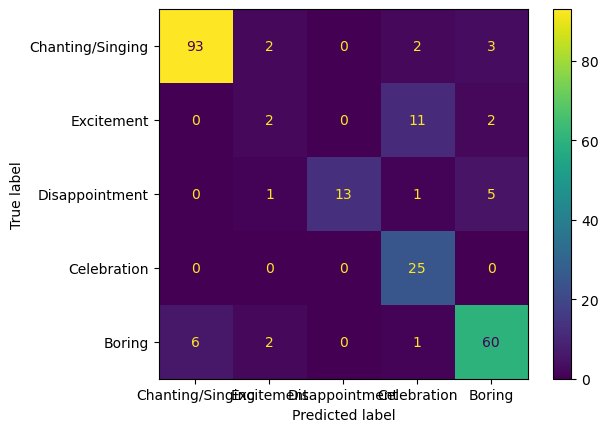

In [17]:
cmd = skm.ConfusionMatrixDisplay(
    skm.confusion_matrix(pred.label_ids, pred.predictions.argmax(1)),
    display_labels = meta.get('labels').keys()
)
cmd.plot()

print(skm.classification_report(pred.label_ids, pred.predictions.argmax(1)))

In [18]:
id2label = {v:k for k,v in meta['labels'].items()}

In [19]:
print(classification_report(pred.label_ids, pred.predictions.argmax(1)))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       100
           1       0.29      0.13      0.18        15
           2       1.00      0.65      0.79        20
           3       0.62      1.00      0.77        25
           4       0.86      0.87      0.86        69

    accuracy                           0.84       229
   macro avg       0.74      0.72      0.71       229
weighted avg       0.84      0.84      0.83       229



  precision    recall  f1-score   support

           0       0.99      0.85      0.91       100
           1       0.67      0.27      0.38        15
           2       0.63      0.60      0.62        20
           3       0.74      1.00      0.85        25
           4       0.79      0.96      0.86        69

    accuracy                           0.84       229
   macro avg       0.76      0.73      0.72       229
weighted avg       0.85      0.84      0.83       229



import transformers

batch_size = 16
args = transformers.TrainingArguments(
    f'{model_name.split("/")[-1]}-ft_stadium',

    learning_rate=2e-5,
    warmup_ratio=0.1,

    eval_strategy = "steps",
    eval_steps = 10,
    logging_steps=10,

    save_strategy = "no",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    gradient_accumulation_steps=2,
    num_train_epochs=10,
    metric_for_best_model="weighted_f1",
    load_best_model_at_end=False,
    push_to_hub=False,
)

In [20]:
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(1), normalize='true')

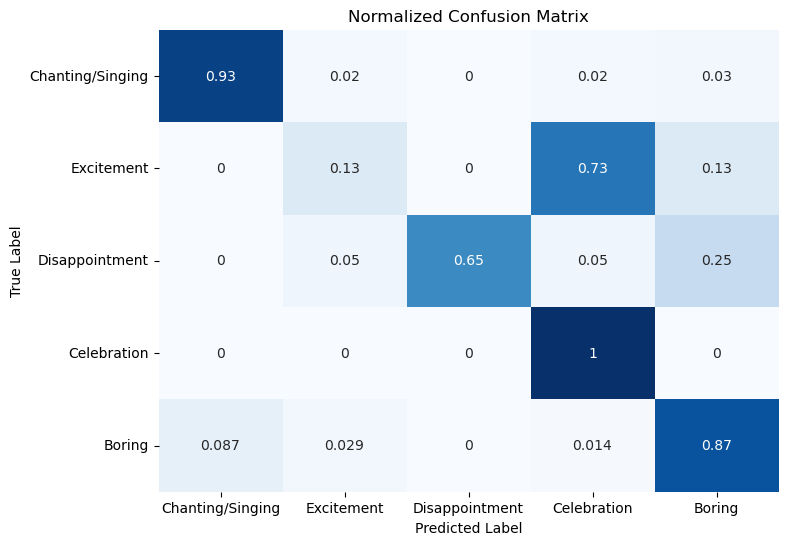

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()